In [ ]:
import json
import csv
import re
from collections import defaultdict
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import matplotlib.pyplot as plt

CLEANING THE TWEETS

In [12]:


input_file_path = '/content/part-00000'
cleaned_output_file_path = '/content/sorted_frenchtweets_with_cleaned_text.csv'


def clean_tweet(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove retweet indicator
    text = re.sub(r"RT\s+", '', text)
    # Remove mentions (@usernames)
    text = re.sub(r"@\w+", '', text)
    # Remove hashtags
    text = re.sub(r"#\w+", '', text)
    # Remove colons
    text = text.replace(":", '')
    # Remove extra whitespace
    text = re.sub(r"\s+", ' ', text).strip()
    return text


# Dictionary to store tweets and their related retweets, quotes, and replies
tweet_groups = defaultdict(list)


total_tweets = 0

with open(input_file_path, 'r') as file:
    for line in file:
        try:
            tweet = json.loads(line)
            tweet_id = tweet.get("id_str", None)
            user_id = tweet.get("user", {}).get("id_str", None)
            tweet_text = tweet.get("text", None)

            # Determine the type of tweet
            tweet_type = "tweet"
            parent_tweet_id = tweet_id

            if "retweeted_status" in tweet:
                tweet_type = "retweet"
                parent_tweet_id = tweet.get("retweeted_status", {}).get("id_str", tweet_id)
            elif "quoted_status" in tweet:
                tweet_type = "quote"
                parent_tweet_id = tweet.get("quoted_status", {}).get("id_str", tweet_id)
            elif tweet.get("in_reply_to_status_id_str"):
                tweet_type = "reply"
                parent_tweet_id = tweet.get("in_reply_to_status_id_str")

            if tweet_id and user_id and tweet_text:
                total_tweets += 1
                cleaned_text = clean_tweet(tweet_text)
                tweet_entry = {
                    "tweet_id": tweet_id,
                    "user_id": user_id,
                    "tweet_type": tweet_type,
                    "cleaned_tweet_text": cleaned_text,
                }

                # Group tweets by their parent tweet ID
                tweet_groups[parent_tweet_id].append(tweet_entry)

        except json.JSONDecodeError:
            continue


sorted_tweets = []
for parent_id, group in tweet_groups.items():

    group.sort(key=lambda x: x['tweet_type'] != 'tweet')
    sorted_tweets.extend(group)


with open(cleaned_output_file_path, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ["tweet_id", "user_id", "tweet_type", "cleaned_tweet_text"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for tweet in sorted_tweets:
        writer.writerow(tweet)

print(f"Sorted CSV file created at: {cleaned_output_file_path}")
print(f"Total number of tweets processed: {total_tweets}")




Sorted CSV file created at: /content/sorted_frenchtweets_with_cleaned_text.csv
Total number of tweets processed: 12073


CODE FOR FRENCH LANGUAGE

In [14]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# Load model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Labels for sentiment analysis
labels = ["1 star", "2 stars", "3 stars", "4 stars", "5 stars"]
star_to_sentiment = {
    "1 star": "Very Negative",
    "2 stars": "Negative",
    "3 stars": "Neutral",
    "4 stars": "Positive",
    "5 stars": "Very Positive",
}

# Function to analyze sentiment
def analyze_sentiment(text):
    """
    Analyzes sentiment of the given text using the BERT model.
    """
    if not isinstance(text, str) or not text.strip():
        return {label: 0 for label in labels}  # Return zero scores for invalid input
    encoded_tweet = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    output = model(**encoded_tweet)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return {labels[i]: scores[i] for i in range(len(scores))}

# Input and output file paths
input_file_path = "/content/sorted_frenchtweets_with_cleaned_text.csv"
output_file_path = "/content/tweets_with_sentiments.csv"

# Load dataset
df = pd.read_csv(input_file_path)

# Ensure all text data is a string
df["cleaned_tweet_text"] = df["cleaned_tweet_text"].fillna("").astype(str)

# Perform sentiment analysis
sentiments = []
for tweet in df["cleaned_tweet_text"]:
    scores = analyze_sentiment(tweet)
    label = max(scores, key=scores.get)  # Choose the label with the highest score
    sentiments.append(star_to_sentiment[label])  # Map the label to a human-readable sentiment

# Add results to the dataframe
df["sentiment"] = sentiments

# Save the results to a CSV file
df.to_csv(output_file_path, index=False)

print(f"Sentiment analysis completed for the entire file. Results saved to: {output_file_path}")


Sentiment analysis completed for the entire file. Results saved to: /content/tweets_with_sentiments.csv


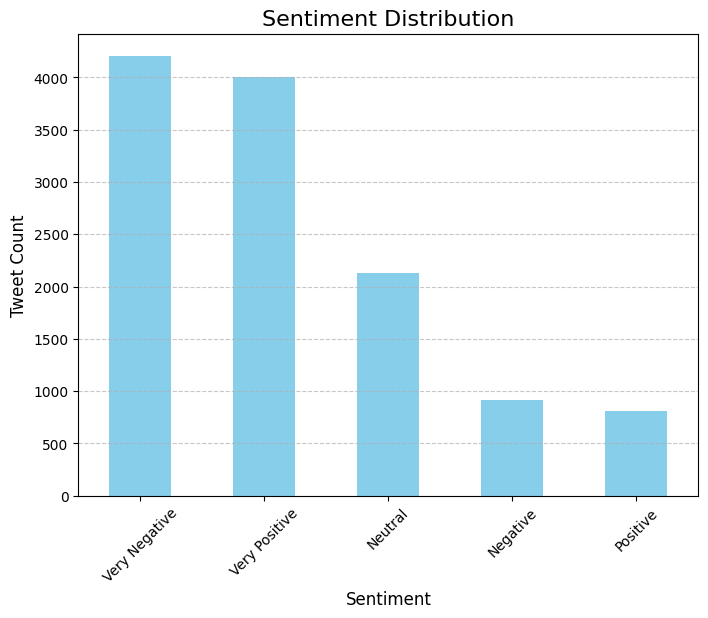

No 'confidence' column found. Skipping confidence visualization.


In [15]:


output_file_path = "/content/tweets_with_sentiments.csv"
df = pd.read_csv(output_file_path)


if "sentiment" not in df.columns:
    raise ValueError("The dataset must contain a 'sentiment' column.")

# Visualize the distribution of sentiments
def plot_sentiment_distribution(df):
    """
    Creates a bar chart showing the distribution of sentiment labels.
    """
    sentiment_counts = df["sentiment"].value_counts()
    sentiment_counts.plot(kind="bar", color="skyblue", figsize=(8, 6))
    plt.title("Sentiment Distribution", fontsize=16)
    plt.xlabel("Sentiment", fontsize=12)
    plt.ylabel("Tweet Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

def plot_sentiment_confidence(df):
    if "confidence" not in df.columns:
        print("No 'confidence' column found. Skipping confidence visualization.")
        return

    confidence_means = df.groupby("sentiment")["confidence"].mean()
    confidence_means.plot(kind="bar", color="lightgreen", figsize=(8, 6))
    plt.title("Average Confidence by Sentiment", fontsize=16)
    plt.xlabel("Sentiment", fontsize=12)
    plt.ylabel("Average Confidence Score", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


plot_sentiment_distribution(df)
plot_sentiment_confidence(df)


In [16]:
import pandas as pd


file_path = '/content/tweets_with_sentiments.csv'
df = pd.read_csv(file_path)

# Total number of tweets
total_tweets = df.shape[0]
print("Total number of tweets:", total_tweets)

# Count of each sentiment
if 'sentiment' in df.columns:
    sentiment_counts = df['sentiment'].value_counts()
    print("Count of each sentiment:\n", sentiment_counts)
else:
    print("The 'sentiment' column was not found in the dataset.")

Total number of tweets: 12073
Count of each sentiment:
 sentiment
Very Negative    4208
Very Positive    4004
Neutral          2133
Negative          914
Positive          814
Name: count, dtype: int64
